In [1]:
import collections
import enum
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.preprocessing
import typing
import os

In [2]:
np.set_printoptions(formatter={'float': '{:.4f}'.format})

# Data Parsing and Preprocessing

In [3]:
adult_train = pd.read_csv(
    'adult.data.csv',
    names=[
        'Age',
        'Workclass',
        'fnlwgt',
        'Education',
        'Education-num',
        'Martial Status',
        'Occupation',
        'Relationship',
        'Race',
        'Sex',
        'Capital Gain',
        'Capital Loss',
        'Hours per week',
        'Country',
        'Target',
    ],
    sep=r'\s*,\s*',
    engine='python',
    na_values='?',
)
adult_train.head(10)

,Age,Workclass,fnlwgt,Education,Education-num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [4]:
adult_test = pd.read_csv(
    'adult.test.csv',
    names=[
        'Age',
        'Workclass',
        'fnlwgt',
        'Education',
        'Education-num',
        'Martial Status',
        'Occupation',
        'Relationship',
        'Race',
        'Sex',
        'Capital Gain',
        'Capital Loss',
        'Hours per week',
        'Country',
        'Target',
    ],
    sep=r'\s*,\s*',
    engine='python',
    na_values='?',
)
adult_test.head()

,Age,Workclass,fnlwgt,Education,Education-num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


For further processing, we use the continuous columns as well as the preprocessed qualitative columns. We did not use the educational levels as introduced in the exercise sheet, because there already is an education column with integers per educational status ordered in a natural rank.

In [5]:
adult_train_p = adult_train.copy()
adult_train_p = adult_train_p.loc[:, adult_train.dtypes == 'int64'].assign(
    private=np.array(adult_train['Workclass'] == 'Private', dtype=int),
    self_employed=np.array((adult_train['Workclass'] == 'Self-emp-not-inc') | (adult_train['Workclass'] == 'Self-emp-inc'), dtype=int),
    government_employed=np.array((adult_train['Workclass'] == 'Federal-gov') | (adult_train['Workclass'] == 'Local-gov') | (adult_train['Workclass'] == 'State-gov'), dtype=int),
    unemployed=np.array((adult_train['Workclass'] == 'Without-pay') | (adult_train['Workclass'] == 'Never-worked'), dtype=int),
    sex=np.array(adult_train['Sex'] == 'Male', dtype=int)
)
adult_train_p_target = np.array(adult_train['Target'] == '>50K', dtype=int)

adult_train_p.head()

,Age,fnlwgt,Education-num,Capital Gain,Capital Loss,Hours per week,private,self_employed,government_employed,unemployed,sex
0,39,77516,13,2174,0,40,0,0,1,0,1
1,50,83311,13,0,0,13,0,1,0,0,1
2,38,215646,9,0,0,40,1,0,0,0,1
3,53,234721,7,0,0,40,1,0,0,0,1
4,28,338409,13,0,0,40,1,0,0,0,0


# k-Nearest-Neighbour
The following class is the same discrete KNN classifier as in exercise 1.

In [6]:
class DiscreteKNN(object):
    def __init__(self, k: int, classes: enum.Enum):
        self.trainData = np.array([], dtype=np.float)
        self.trainLabels = np.array([])
        self.k = k
        self.classes = classes

    def train(self, trainData, trainLabels):
        self.trainData = np.array(trainData)
        self.trainLabels = np.array(trainLabels)

    def predict(self, predicate: typing.List[typing.List[float]]):
        distances = np.linalg.norm(self.trainData - np.array(predicate), axis=1)
        kSmallest = np.argpartition(distances, self.k)[0:self.k]

        return self.classes(collections.Counter(self.trainLabels[kSmallest]).most_common(1)[0][0])

    def computeEmpiricalLoss(self, testLabels, predictedLabels):
        return (1.0 / len(predictedLabels)) * np.sum([int(a != b) for (a, b) in zip(testLabels, predictedLabels)])

Now we define an enum class for the two target labels of the data: >50K and <=50K

In [7]:
class IncomeStatus(enum.Enum):
    LOWER = 0
    HIGHER = 1

For use in the KNN classifier, each column of the train data gets scaled to the interval [0, 100], otherwise the distance of two points would have a different meaning for different predictors.

In [8]:
adult_train_p_s = adult_train_p.copy()

for i in range(0, adult_train_p_s.shape[1]):
    colmin = adult_train_p_s.iloc[:, i] - adult_train_p_s.iloc[:, i].min()
    colminmax = colmin.max()
    adult_train_p_s.iloc[:, i] = colmin * 100 / colminmax

adult_train_p_s.head()

,Age,fnlwgt,Education-num,Capital Gain,Capital Loss,Hours per week,private,self_employed,government_employed,unemployed,sex
0,30.136986,4.430190,80.000000,2.174022,0.0,39.795918,0.0,0.0,100.0,0.0,100.0
1,45.205479,4.823760,80.000000,0.000000,0.0,12.244898,0.0,100.0,0.0,0.0,100.0
2,28.767123,13.811345,53.333333,0.000000,0.0,39.795918,100.0,0.0,0.0,0.0,100.0
3,49.315068,15.106831,40.000000,0.000000,0.0,39.795918,100.0,0.0,0.0,0.0,100.0
4,15.068493,22.148843,80.000000,0.000000,0.0,39.795918,100.0,0.0,0.0,0.0,0.0


Do the same processing for the test data.

In [9]:
adult_test_p = adult_test.copy()
adult_test_p = adult_test_p.loc[:, adult_test.dtypes == 'int64'].assign(
    private=np.array(adult_test['Workclass'] == 'Private', dtype=int),
    self_employed=np.array((adult_test['Workclass'] == 'Self-emp-not-inc') | (adult_test['Workclass'] == 'Self-emp-inc'), dtype=int),
    government_employed=np.array((adult_test['Workclass'] == 'Federal-gov') | (adult_test['Workclass'] == 'Local-gov') | (adult_test['Workclass'] == 'State-gov'), dtype=int),
    unemployed=np.array((adult_test['Workclass'] == 'Without-pay') | (adult_test['Workclass'] == 'Never-worked'), dtype=int),
    sex=np.array(adult_test['Sex'] == 'Male', dtype=int)
)
adult_test_p_target = np.array(adult_test['Target'] == '>50K', dtype=int)

adult_test_p_s = adult_test_p.copy()

for i in range(0, adult_test_p_s.shape[1]):
    colmin = adult_test_p_s.iloc[:, i] - adult_test_p_s.iloc[:, i].min()
    colminmax = colmin.max()
    adult_test_p_s.iloc[:, i] = colmin * 100 / colminmax

adult_test_p_s.head()

,Age,fnlwgt,Education-num,Capital Gain,Capital Loss,Hours per week,private,self_employed,government_employed,unemployed,sex
0,10.958904,14.443012,40.000000,0.000000,0.0,39.795918,100.0,0.0,0.0,0.0,100.0
1,28.767123,5.167688,53.333333,0.000000,0.0,50.000000,100.0,0.0,0.0,0.0,100.0
2,15.068493,21.901093,73.333333,0.000000,0.0,39.795918,0.0,0.0,100.0,0.0,100.0
3,36.986301,9.941784,60.000000,7.688077,0.0,39.795918,100.0,0.0,0.0,0.0,100.0
4,1.369863,6.094151,60.000000,0.000000,0.0,29.591837,0.0,0.0,0.0,0.0,0.0


We now run the KNN classifier with a k-value of 3 for the test dataset given the train dataset.

In [10]:
dknn = DiscreteKNN(3, IncomeStatus)
dknn.train(adult_train_p_s, adult_train_p_target)
correct = 0
mispredicts = 0
c = 0

for test_point in np.array(adult_test_p_s):
    if dknn.predict(test_point).value == adult_test_p_target[c]:
        correct = correct + 1
    else:
        mispredicts = mispredicts + 1
    
    c = c + 1

accuracy = 100 * float(correct) / adult_test_p_s.shape[0]

print('Test Points: {:d}'.format(adult_test_p_s.shape[0]))
print('Correct: {:d}'.format(correct))
print('Mispredictions: {:d}'.format(mispredicts))
print('Accurary: {:.4f}%'.format(accuracy))

Test Points: 16281
Correct: 13070
Mispredictions: 3211
Accurary: 80.2776%


We see that we already get an overall not too bad accuracy of around 80%, meaning 4 out of 5 test points are classified correctly. Still, in absolut numbers, this is more than 3000 mispredicts for the rather small test dataset given. In addition the execution time is quite high.

# Logistic Regression

Left pad data for easier calculation of theta via matrix operations.

In [12]:
adult_train_pp = adult_train_p.copy()
adult_train_pp.insert(0, 'pad', np.ones(adult_train_pp.shape[0]))
adult_train_pp.head()

,pad,Age,fnlwgt,Education-num,Capital Gain,Capital Loss,Hours per week,private,self_employed,government_employed,unemployed,sex
0,1.0,39,77516,13,2174,0,40,0,0,1,0,1
1,1.0,50,83311,13,0,0,13,0,1,0,0,1
2,1.0,38,215646,9,0,0,40,1,0,0,0,1
3,1.0,53,234721,7,0,0,40,1,0,0,0,1
4,1.0,28,338409,13,0,0,40,1,0,0,0,0


In [14]:
def get_htheta(cross_product):
    return 0.5 + 0.5 * np.tanh(cross_product / 2)

In [15]:
adult_train_p_target = np.expand_dims(adult_train_p_target, axis=1)

In [17]:
theta = np.zeros([adult_train_pp.shape[1], 1], dtype='float64')
cross_product = adult_train_pp.dot(theta)
htheta = np.apply_along_axis(get_htheta, 0, cross_product)
deriva = np.transpose(adult_train_pp).dot(adult_train_p_target - htheta)
theta_new = theta + 0.01 * deriva
theta_new

,0
pad,-8.439500e+01
Age,-2.811655e+03
fnlwgt,-1.615539e+07
Education-num,-7.307150e+02
Capital Gain,1.386750e+05
Capital Loss,1.076570e+03
Hours per week,-3.017880e+03
private,-6.385000e+01
self_employed,-4.825000e+00
government_employed,-8.345000e+00


In [26]:
theta = np.zeros([adult_train_pp.shape[1], 1], dtype='float64')
thetas = []

for i in range(0, 100):
    cross_product = adult_train_pp.dot(theta)
    htheta = np.apply_along_axis(get_htheta, 0, cross_product)
    deriva = np.transpose(adult_train_pp).dot(adult_train_p_target - htheta)
    theta = theta + 0.01 * deriva
    
    thetas.append(np.array(theta))

In [27]:
theta

,0
pad,-1.723850e+02
Age,3.750531e+04
fnlwgt,-4.390918e+07
Education-num,1.017556e+04
Capital Gain,2.065926e+07
Capital Loss,8.325455e+05
Hours per week,3.225667e+04
private,-6.174500e+02
self_employed,4.381550e+02
government_employed,2.718050e+02


Example plot of one of the theta values.

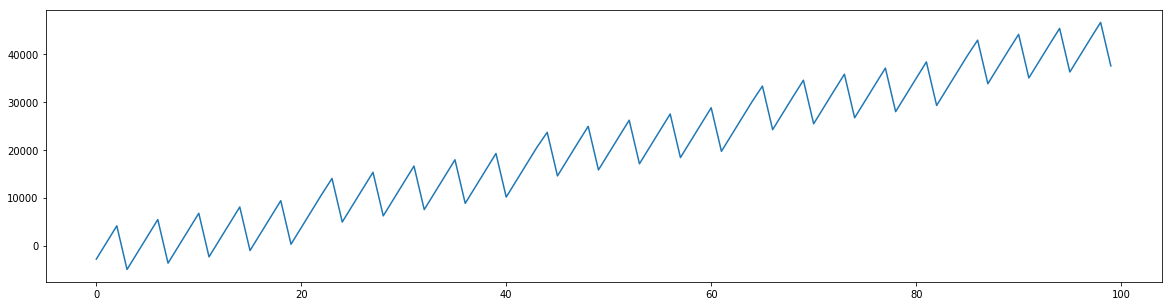

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(0, len(thetas)), np.array(thetas)[:, 1])
plt.show()

Since the Theta values do not seem to converge, we stoped here. It doesn't seem to make sense to plug the test dataset into a logit model based on apparently random parameters.